# Day 6: Bayesian Thinking for Finance
## Week 2: Statistics & Probability for Finance

---

**Learning Objectives:**
- Understand Bayes' theorem and its applications
- Apply Bayesian updating for parameter estimation
- Compare frequentist vs Bayesian approaches
- Build intuition for probabilistic reasoning

In [1]:
# Day 6 Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')

# Load market data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                 index_col='Date', parse_dates=True)
prices = df[['AAPL', 'MSFT', 'SPY', 'JPM']].dropna()
returns = prices.pct_change().dropna()

print("=" * 60)
print("BAYESIAN THINKING FOR FINANCE - DAY 6")
print("=" * 60)

BAYESIAN THINKING FOR FINANCE - DAY 6


## 1. Bayes' Theorem

$$P(\theta|D) = \frac{P(D|\theta) \cdot P(\theta)}{P(D)}$$

- **P(θ)**: Prior - What we believed before seeing data
- **P(D|θ)**: Likelihood - How probable is the data given θ
- **P(θ|D)**: Posterior - Updated belief after seeing data
- **P(D)**: Evidence - Normalizing constant

BAYESIAN UPDATING: Estimating True Mean Return

Prior Belief:
  Mean: 0.000400 (10.08% annual)
  Std:  0.001000

Data (Sample):
  Mean: 0.000712 (17.94% annual)
  Std:  0.012426
  n:    1770

Posterior Belief:
  Mean: 0.000687 (17.31% annual)
  Std:  0.000283


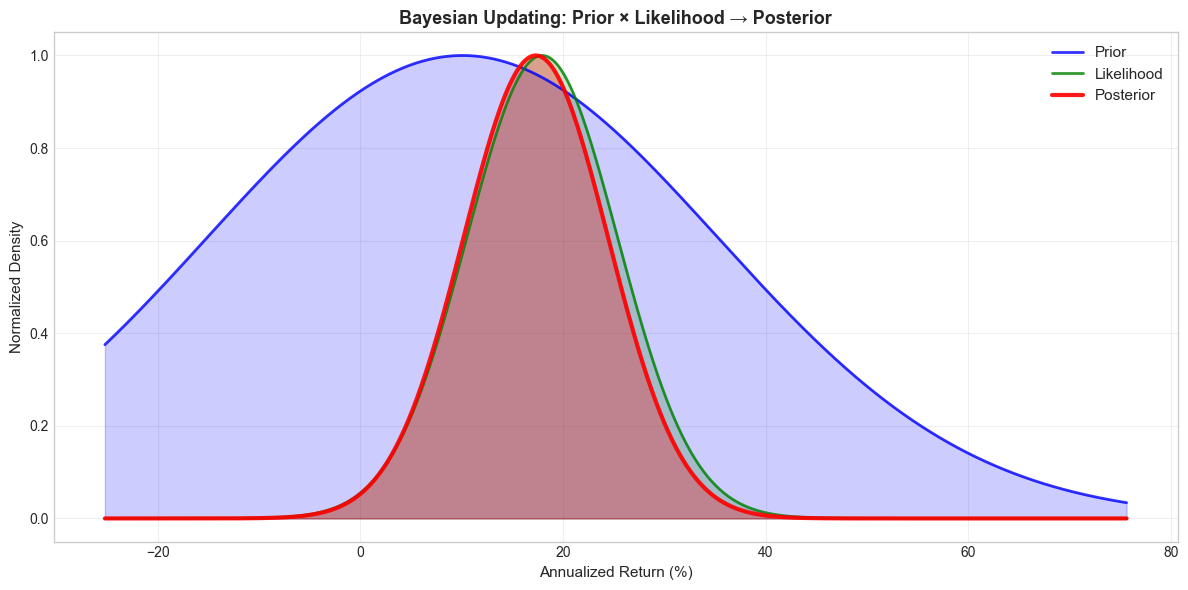


📊 Posterior combines prior beliefs with observed data!


In [2]:
# Bayesian Updating Example: Estimating True Mean Return
print("=" * 60)
print("BAYESIAN UPDATING: Estimating True Mean Return")
print("=" * 60)

spy_returns = returns['SPY'].values

# Prior: Based on historical market expectations
prior_mean = 0.0004  # ~10% annual
prior_std = 0.001    # Uncertainty in prior

# Data
sample_mean = np.mean(spy_returns)
sample_std = np.std(spy_returns, ddof=1)
n = len(spy_returns)

# Posterior (conjugate prior for Normal-Normal model)
# Posterior precision = Prior precision + Data precision
prior_precision = 1 / prior_std**2
data_precision = n / sample_std**2
posterior_precision = prior_precision + data_precision

# Posterior mean = weighted average
posterior_mean = (prior_precision * prior_mean + data_precision * sample_mean) / posterior_precision
posterior_std = np.sqrt(1 / posterior_precision)

print(f"\nPrior Belief:")
print(f"  Mean: {prior_mean:.6f} ({prior_mean * 252:.2%} annual)")
print(f"  Std:  {prior_std:.6f}")

print(f"\nData (Sample):")
print(f"  Mean: {sample_mean:.6f} ({sample_mean * 252:.2%} annual)")
print(f"  Std:  {sample_std:.6f}")
print(f"  n:    {n}")

print(f"\nPosterior Belief:")
print(f"  Mean: {posterior_mean:.6f} ({posterior_mean * 252:.2%} annual)")
print(f"  Std:  {posterior_std:.6f}")

# Visualize prior, likelihood, and posterior
fig, ax = plt.subplots(figsize=(12, 6))

x = np.linspace(-0.001, 0.003, 1000)

# Prior
prior_pdf = stats.norm.pdf(x, prior_mean, prior_std)
ax.plot(x * 252 * 100, prior_pdf / max(prior_pdf), 'b-', lw=2, label='Prior', alpha=0.8)
ax.fill_between(x * 252 * 100, prior_pdf / max(prior_pdf), alpha=0.2, color='blue')

# Likelihood (scaled)
likelihood_std = sample_std / np.sqrt(n)
likelihood_pdf = stats.norm.pdf(x, sample_mean, likelihood_std)
ax.plot(x * 252 * 100, likelihood_pdf / max(likelihood_pdf), 'g-', lw=2, label='Likelihood', alpha=0.8)
ax.fill_between(x * 252 * 100, likelihood_pdf / max(likelihood_pdf), alpha=0.2, color='green')

# Posterior
posterior_pdf = stats.norm.pdf(x, posterior_mean, posterior_std)
ax.plot(x * 252 * 100, posterior_pdf / max(posterior_pdf), 'r-', lw=3, label='Posterior', alpha=0.9)
ax.fill_between(x * 252 * 100, posterior_pdf / max(posterior_pdf), alpha=0.3, color='red')

ax.set_xlabel('Annualized Return (%)', fontsize=11)
ax.set_ylabel('Normalized Density', fontsize=11)
ax.set_title('Bayesian Updating: Prior × Likelihood → Posterior', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Posterior combines prior beliefs with observed data!")

## 2. Sequential Bayesian Updating

SEQUENTIAL BAYESIAN UPDATING


/var/folders/7l/31hylb_513bbgfbz8nnsgp840000gn/T/ipykernel_14397/3588767537.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_returns = returns['SPY'].resample('M').mean()


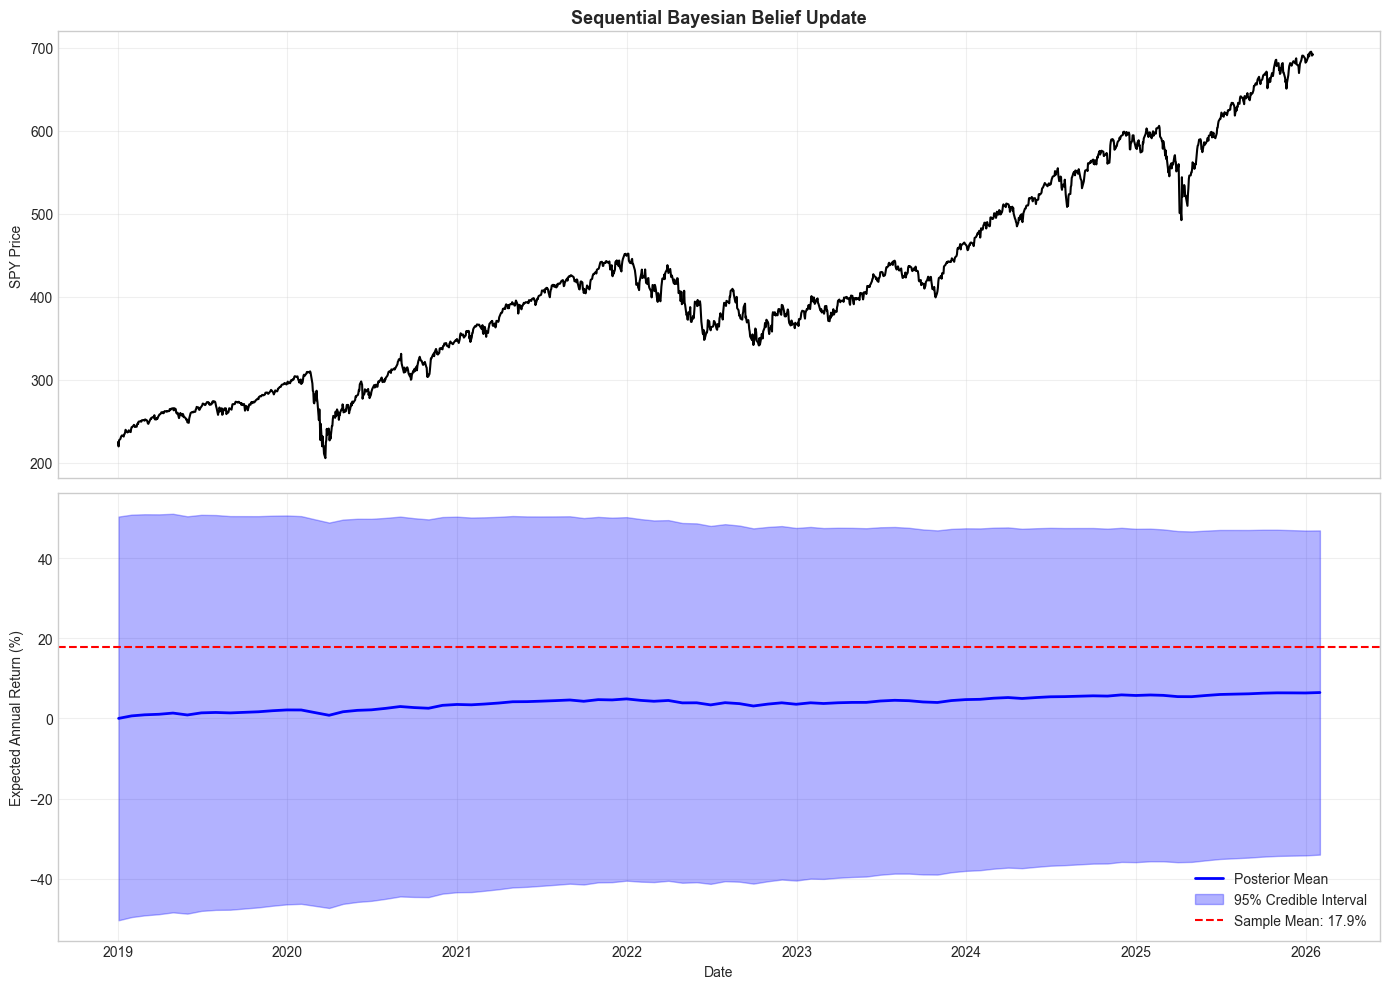


Final Posterior:
  Mean: 6.46% annual
  Std:  20.24%


In [3]:
# Sequential Updating: Watch beliefs evolve as data arrives
print("=" * 60)
print("SEQUENTIAL BAYESIAN UPDATING")
print("=" * 60)

# Start with a skeptical prior (0% return)
prior_mu = 0.0
prior_var = 0.001**2  # Wide prior

# Known variance (simplification)
known_var = np.var(spy_returns)

# Track posterior evolution
posterior_means = [prior_mu]
posterior_vars = [prior_var]
dates = [returns.index[0]]

# Update month by month
monthly_returns = returns['SPY'].resample('M').mean()

current_mu = prior_mu
current_var = prior_var

for date, ret in monthly_returns.items():
    # Bayesian update
    data_precision = 1 / known_var
    prior_precision = 1 / current_var
    
    new_precision = prior_precision + data_precision
    new_mu = (prior_precision * current_mu + data_precision * ret) / new_precision
    new_var = 1 / new_precision
    
    current_mu = new_mu
    current_var = new_var
    
    posterior_means.append(current_mu)
    posterior_vars.append(current_var)
    dates.append(date)

# Convert to annual
posterior_means_ann = np.array(posterior_means) * 252 * 100
posterior_stds_ann = np.sqrt(posterior_vars) * 252 * 100

# Visualize evolution
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Price
prices['SPY'].plot(ax=axes[0], color='black', lw=1.5)
axes[0].set_ylabel('SPY Price', fontsize=10)
axes[0].set_title('Sequential Bayesian Belief Update', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Posterior evolution
axes[1].plot(dates, posterior_means_ann, 'b-', lw=2, label='Posterior Mean')
axes[1].fill_between(dates, 
                     posterior_means_ann - 2*posterior_stds_ann,
                     posterior_means_ann + 2*posterior_stds_ann,
                     alpha=0.3, color='blue', label='95% Credible Interval')
axes[1].axhline(np.mean(spy_returns) * 252 * 100, color='red', linestyle='--', 
                label=f'Sample Mean: {np.mean(spy_returns) * 252:.1%}')
axes[1].set_xlabel('Date', fontsize=10)
axes[1].set_ylabel('Expected Annual Return (%)', fontsize=10)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Posterior:")
print(f"  Mean: {posterior_means_ann[-1]:.2f}% annual")
print(f"  Std:  {posterior_stds_ann[-1]:.2f}%")

## 3. Bayesian A/B Testing for Strategies

BAYESIAN STRATEGY COMPARISON

Strategy A (Momentum): Mean = 12.43%
Strategy B (Buy-Hold): Mean = 17.94%

Bayesian Analysis:
  P(Momentum > Buy-Hold) = 26.0%
  P(Buy-Hold > Momentum) = 74.0%

Expected Outperformance: -5.52% ± 8.61%


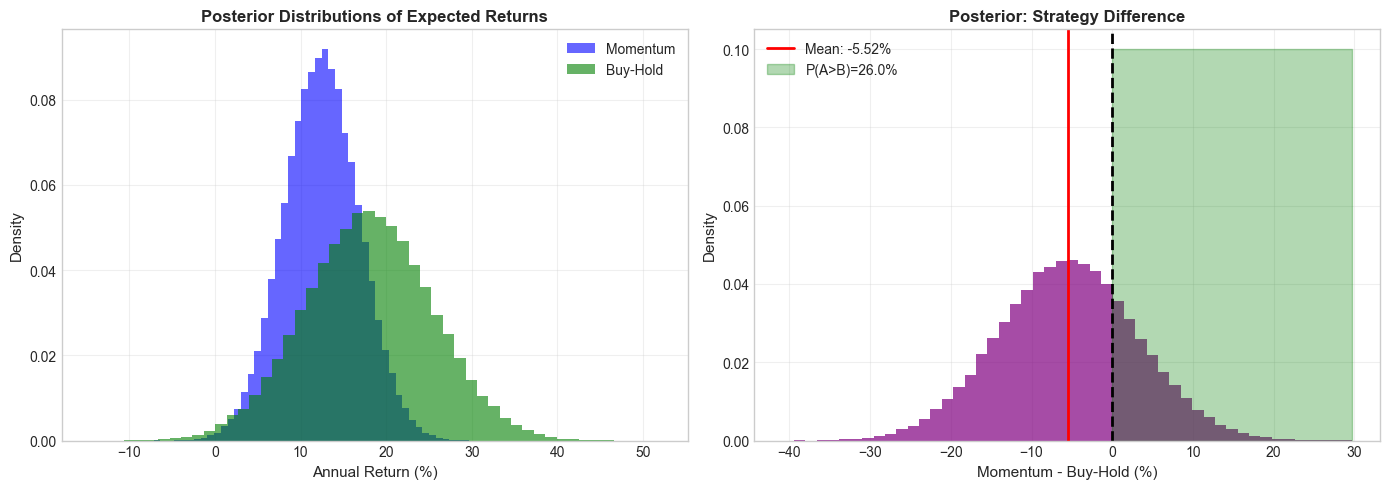

In [4]:
# Bayesian Strategy Comparison
print("=" * 60)
print("BAYESIAN STRATEGY COMPARISON")
print("=" * 60)

# Two strategies: Momentum vs Buy-and-Hold
spy_ret = returns['SPY']

# Momentum strategy
momentum_signal = spy_ret.rolling(21).mean().shift(1) > 0
strategy_A = spy_ret.where(momentum_signal, 0).dropna()  # Momentum
strategy_B = spy_ret.loc[strategy_A.index]  # Buy-and-Hold (same period)

print(f"\nStrategy A (Momentum): Mean = {strategy_A.mean()*252:.2%}")
print(f"Strategy B (Buy-Hold): Mean = {strategy_B.mean()*252:.2%}")

# Simulate from posterior distributions
np.random.seed(42)
n_samples = 100000

# Bootstrap posteriors (non-informative prior)
A_posterior = np.random.normal(
    np.mean(strategy_A), 
    np.std(strategy_A) / np.sqrt(len(strategy_A)),
    n_samples
) * 252  # Annualize

B_posterior = np.random.normal(
    np.mean(strategy_B), 
    np.std(strategy_B) / np.sqrt(len(strategy_B)),
    n_samples
) * 252  # Annualize

# Probability that A beats B
prob_A_better = np.mean(A_posterior > B_posterior)

print(f"\nBayesian Analysis:")
print(f"  P(Momentum > Buy-Hold) = {prob_A_better:.1%}")
print(f"  P(Buy-Hold > Momentum) = {1-prob_A_better:.1%}")

# Difference distribution
diff_posterior = A_posterior - B_posterior
print(f"\nExpected Outperformance: {np.mean(diff_posterior):.2%} ± {np.std(diff_posterior):.2%}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Strategy posteriors
axes[0].hist(A_posterior * 100, bins=50, alpha=0.6, label='Momentum', color='blue', density=True)
axes[0].hist(B_posterior * 100, bins=50, alpha=0.6, label='Buy-Hold', color='green', density=True)
axes[0].set_xlabel('Annual Return (%)', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('Posterior Distributions of Expected Returns', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Difference distribution
axes[1].hist(diff_posterior * 100, bins=50, alpha=0.7, color='purple', density=True)
axes[1].axvline(0, color='black', lw=2, linestyle='--')
axes[1].axvline(np.mean(diff_posterior) * 100, color='red', lw=2, label=f'Mean: {np.mean(diff_posterior)*100:.2f}%')
axes[1].fill_between(np.linspace(0, max(diff_posterior)*100, 100), 0, 0.1, alpha=0.3, color='green', label=f'P(A>B)={prob_A_better:.1%}')
axes[1].set_xlabel('Momentum - Buy-Hold (%)', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].set_title('Posterior: Strategy Difference', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Bayesian vs Frequentist: Key Differences

In [5]:
# Comparison: Bayesian vs Frequentist
print("=" * 60)
print("BAYESIAN vs FREQUENTIST COMPARISON")
print("=" * 60)

spy_ret = returns['SPY'].values
n = len(spy_ret)

# Frequentist approach
freq_mean = np.mean(spy_ret)
freq_se = np.std(spy_ret, ddof=1) / np.sqrt(n)
freq_ci_lower = freq_mean - 1.96 * freq_se
freq_ci_upper = freq_mean + 1.96 * freq_se

# Bayesian approach (with weakly informative prior)
prior_mean = 0.0005
prior_std = 0.002
prior_precision = 1 / prior_std**2
data_precision = n / np.var(spy_ret)
post_precision = prior_precision + data_precision
post_mean = (prior_precision * prior_mean + data_precision * freq_mean) / post_precision
post_std = np.sqrt(1 / post_precision)

bayes_ci_lower = post_mean - 1.96 * post_std
bayes_ci_upper = post_mean + 1.96 * post_std

print(f"\n{'Approach':<15} {'Point Est':<15} {'95% Interval':<30}")
print("-" * 60)
print(f"{'Frequentist':<15} {freq_mean*252:.2%}{'':<7} [{freq_ci_lower*252:.2%}, {freq_ci_upper*252:.2%}]")
print(f"{'Bayesian':<15} {post_mean*252:.2%}{'':<7} [{bayes_ci_lower*252:.2%}, {bayes_ci_upper*252:.2%}]")

print("\n" + "=" * 60)
print("KEY PHILOSOPHICAL DIFFERENCES")
print("=" * 60)
print("""
📊 FREQUENTIST:
   - Parameters are fixed (unknown constants)
   - Probability = long-run frequency
   - CI: "95% of intervals would contain true value"
   - No prior beliefs, only data

📊 BAYESIAN:
   - Parameters have distributions
   - Probability = degree of belief
   - Credible Interval: "95% probability true value is here"
   - Combines prior knowledge with data
   
⚠️ In practice:
   - With enough data, both approaches converge
   - Bayesian is useful with limited data or strong priors
   - Frequentist is standard in academic finance
""")

BAYESIAN vs FREQUENTIST COMPARISON

Approach        Point Est       95% Interval                  
------------------------------------------------------------
Frequentist     17.94%        [3.36%, 32.53%]
Bayesian        17.83%        [3.40%, 32.26%]

KEY PHILOSOPHICAL DIFFERENCES

📊 FREQUENTIST:
   - Parameters are fixed (unknown constants)
   - Probability = long-run frequency
   - CI: "95% of intervals would contain true value"
   - No prior beliefs, only data

📊 BAYESIAN:
   - Parameters have distributions
   - Probability = degree of belief
   - Credible Interval: "95% probability true value is here"
   - Combines prior knowledge with data

⚠️ In practice:
   - With enough data, both approaches converge
   - Bayesian is useful with limited data or strong priors
   - Frequentist is standard in academic finance



## 📝 Key Takeaways - Day 6

### Bayes' Theorem:
- Posterior ∝ Likelihood × Prior
- Updates beliefs as new data arrives
- Natural framework for sequential learning

### Applications in Finance:
- Parameter estimation with prior knowledge
- Strategy comparison (Bayesian A/B testing)
- Risk assessment with expert opinions

### Bayesian vs Frequentist:
| Aspect | Frequentist | Bayesian |
|--------|-------------|----------|
| Parameters | Fixed constants | Random variables |
| Probability | Long-run frequency | Degree of belief |
| Prior | None | Incorporated |
| Intervals | Confidence | Credible |

### Interview Questions:
- "Explain Bayes' theorem in a trading context"
- "When would you prefer Bayesian over frequentist methods?"
- "How would you combine expert opinions with data?"
- "What's the difference between a confidence and credible interval?"